In [10]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
from pathlib import Path
import numpy as np
import json
from matplotlib import patheffects
from typing import Dict, Tuple, List
from utils import dref_dataframe, dump_dref

sns.set_style("whitegrid")
sns.set_context("poster", font_scale=0.75)
sns.set_palette("colorblind6")

def parse_frag(file: Path) -> pd.DataFrame:
    raw = file.read_text()
    data = ""
    for line in raw.splitlines():
        data += line + ((len(line) + 31) // 32 * 32 - len(line)) * "0"
    huge_pages = len(data)
    out = np.zeros(huge_pages)
    for i, char in enumerate(data):
        level = int(char)
        assert(0 <= level <= 9)
        out[i] = float(level)
    # out = out.reshape(((huge_pages + 31) // 32, 32))
    return pd.DataFrame(out)

def load_data(max_mem: int, modes: Dict[str, Path]) -> Tuple[pd.DataFrame, List[Dict[str, int]]]:
    datas = []
    for mode, p in modes.items():
        data = pd.read_csv(p / "out_0.csv")
        data["mode"] = mode
        datas.append(data)

    data = pd.concat(datas)
    data["small"] = max_mem - data["small"] * 2**12
    data["huge"] = max_mem - data["huge"] * 2**(12+9)
    data["time"] = data.index
    data = data.melt(
        id_vars=["mode", "time"],
        var_name="measurement",
        value_name="bytes",
        value_vars=["rss", "small", "huge", "cached"])

    times = [json.load((p / "times_0.json").open()) for p in modes.values()]
    for t in times:
        if "shrink" in t:
            t["drop"] = t["shrink"]
        if not isinstance(t["build"], list):
            t["build"] = [t["build"]]
        if not isinstance(t["delay"], list):
            t["delay"] = [t["delay"]]
    return data, times

def y_at(data: pd.DataFrame, x: int):
    return data[data["measurement"] == "huge"][(data["time"] - x).abs() < 2]["bytes"].max()

def relplot(max_mem: int, data: pd.DataFrame, times: List[Dict[str, int]]) -> Tuple[sns.FacetGrid, Dict[str, int]]:
    p = sns.relplot(data=data, kind="line", x="time", y="bytes", col="mode", hue="measurement", height=6, legend=False)
    p.set_titles("{col_name}")
    p.set(ylabel="Memory consumption [GiB]")
    p.set(xlabel="Time [seconds]")
    p.set(ylim=(0, max_mem * 1.1))
    p.set(yticks=[x for x in range(0, max_mem + 1, 2*1024**3)],
        yticklabels=[str(x // 1024**3) for x in range(0, max_mem + 1, 2*1024**3)])



    modes = data["mode"].unique()
    extra_keys = {}

    h = list(p.axes[0][0].get_lines())
    l = list(data["measurement"].unique())
    p.add_legend(handles=h, labels=l, loc="upper center", bbox_to_anchor=(0.31, 0.04), ncol=7, frameon=True)

    p.refline(y=max_mem, color=sns.crayons["Gray"])
    for i, time in enumerate(times):
        axis = p.facet_axis(0, i)
        celld = data[data["mode"] == modes[i]]


        tlast = 0
        j = 0
        prefix = ""
        for tbuild, tdelay in zip(time["build"], time["delay"]):
            axis.axvspan(
                xmin=tlast, xmax=tbuild, ymax=0.91, edgecolor=sns.crayons["Gray"],
                facecolor="white", zorder=-1, hatch="//")

            b_mid = tlast + (tbuild - tlast)/2
            axis.text(b_mid, max_mem * 1.02, "runtime", horizontalalignment="center",
                        path_effects=[patheffects.withStroke(linewidth=5, foreground='white')])

            gib_m = celld[(tlast <= celld["time"])
                & (celld["time"] < tbuild)
                & (celld["measurement"] == "rss")]["bytes"].sum() / 1024**3 / 60
            print(f"{modes[i]}: {gib_m:.2f} GiB*m, {tbuild - tlast} s")
            extra_keys[f"{modes[i]}/{j}/run/gib_m"] = gib_m
            extra_keys[f"{modes[i]}/{j}/run/time"] = tbuild - tlast

            gib = y_at(celld, tbuild + (tdelay - tbuild)/2) / 1024**3
            prefix += f"delay {gib:.2f} GiB, "
            extra_keys[f"{modes[i]}/{j}/delay/gib"] = gib
            tlast = tdelay
            j += 1

        tdelay = time["delay"][-1] if isinstance(time["delay"], list) else time["delay"]
        if "clean" in time and time["clean"]:
            axis.annotate(
                "clean",
                (tdelay, y_at(celld, tdelay) + max_mem/32),
                (tdelay, max_mem * 0.925),
                horizontalalignment="center",
                path_effects=[patheffects.withStroke(linewidth=5, foreground='white')],
                arrowprops={"facecolor": sns.crayons["Violet (Purple)"]})
            tdelay = time["clean"]
            gib = y_at(celld, tdelay) / 1024**3
            prefix += f"clean {gib:.2f} GiB, "
            extra_keys[f"{modes[i]}/clean/gib"] = gib

        axis.annotate(
            "drop",
            (tdelay, y_at(celld, tdelay) + max_mem/32),
            (tdelay, max_mem * 0.85),
            horizontalalignment="center",
            path_effects=[patheffects.withStroke(linewidth=5, foreground='white')],
            arrowprops={"facecolor": "black"})
        gib = y_at(celld, time["drop"]) / 1024**3
        prefix += f"drop {gib:.2f} GiB, "
        extra_keys[f"{modes[i]}/drop/gib"] = gib

        gib_m = celld[celld["measurement"] == "rss"]["bytes"].sum() / 1024**3 / 60
        prefix += f"{gib_m:.2f} GiB*m"
        extra_keys[f"{modes[i]}/gib_m"] = gib_m

        print(f"{modes[i]}: {prefix}")

    return p, extra_keys


def visualize(max_mem: int, modes: Dict[str, Path], save_as: str | None = None) -> sns.FacetGrid:
    data, times = load_data(max_mem, modes)
    p, extra_keys = relplot(max_mem, data, times)
    if save_as:
        p.savefig(Path("compiling") / f"{save_as}.pdf")
        dref_dataframe(save_as, Path("compiling"), ["mode", "measurement", "time"], data)
        with (Path("compiling") / f"{save_as}_extra.dref").open("w+") as f:
            dump_dref(f, save_as, extra_keys)
    return p


## Linux

Baseline: 4.35 GiB*m, 138 s
Baseline: delay 2.17 GiB, clean 2.04 GiB, drop 1.76 GiB, 8.07 GiB*m
HyperAlloc: 5.39 GiB*m, 136 s
HyperAlloc: delay 2.06 GiB, clean 1.92 GiB, drop 0.87 GiB, 9.69 GiB*m


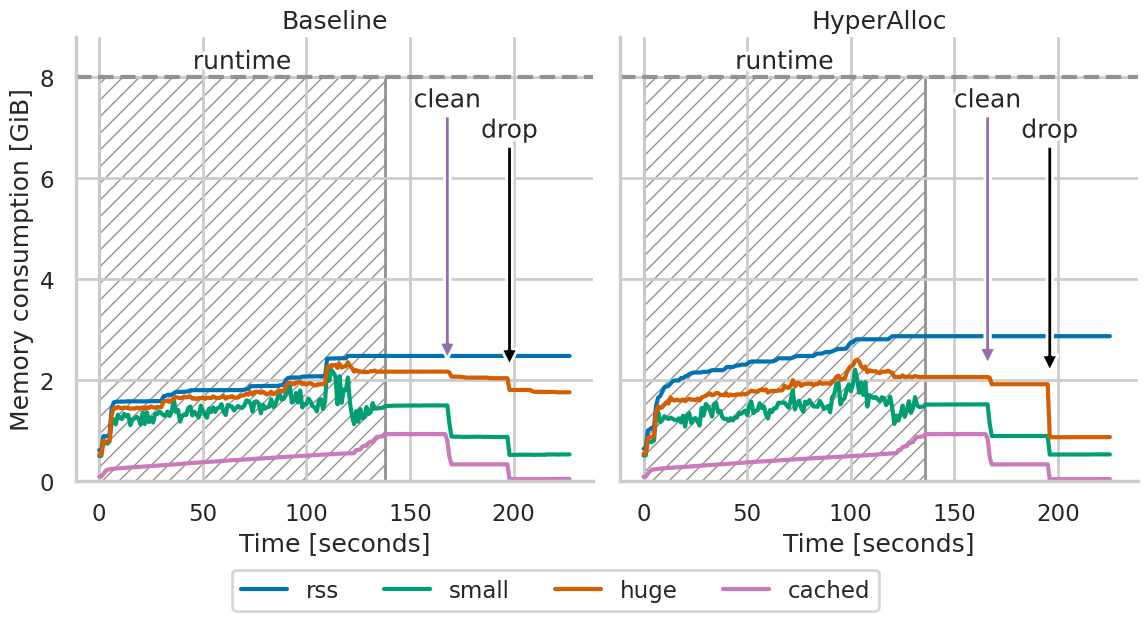

In [11]:
max_mem = 8*1024**3
p = visualize(max_mem, {
    "Baseline": Path("compiling/latest-linux-base-manual"),
    "HyperAlloc": Path("compiling/latest-linux-llfree-manual"),
})

virtio-balloon: 4.28 GiB*m, 137 s
virtio-balloon: delay 1.99 GiB, clean 1.96 GiB, drop 1.77 GiB, 7.32 GiB*m
HyperAlloc: 4.54 GiB*m, 136 s
HyperAlloc: delay 2.11 GiB, clean 1.95 GiB, drop 0.87 GiB, 7.21 GiB*m


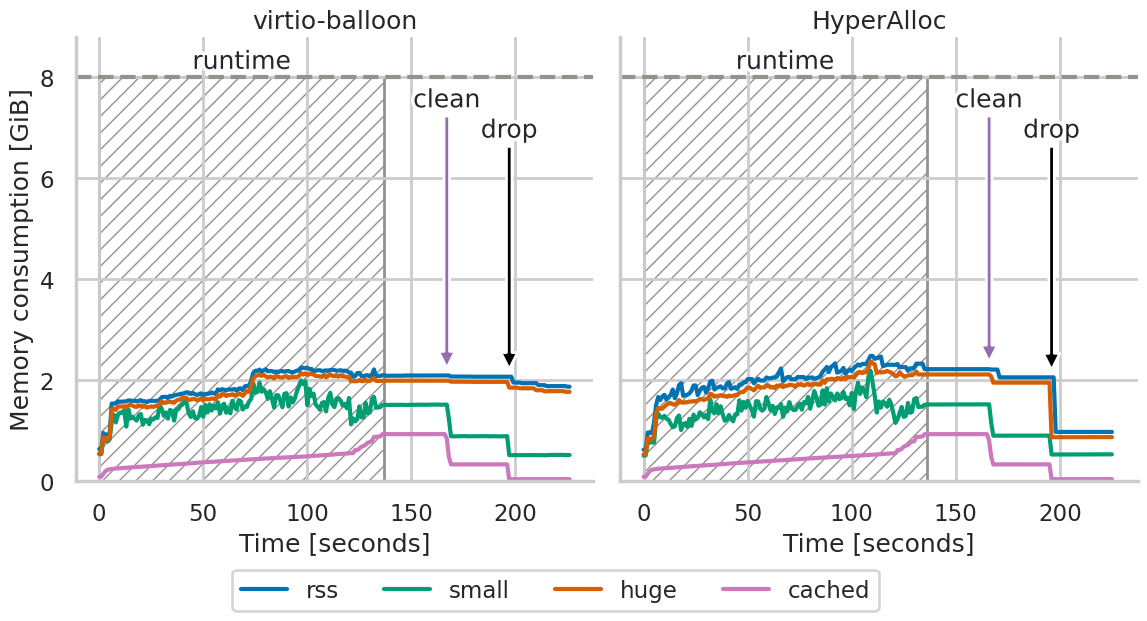

In [12]:
max_mem = 8*1024**3
p = visualize(max_mem, {
    "virtio-balloon": Path("compiling/latest-linux-base-auto"),
    "HyperAlloc": Path("compiling/latest-linux-llfree-auto"),
}, "linux-auto")

virtio-balloon-huge: 4.28 GiB*m, 136 s
virtio-balloon-huge: delay 2.04 GiB, clean 2.02 GiB, drop 1.88 GiB, 7.39 GiB*m
HyperAlloc+VFIO: 4.64 GiB*m, 137 s
HyperAlloc+VFIO: delay 2.12 GiB, clean 1.96 GiB, drop 0.89 GiB, 7.36 GiB*m


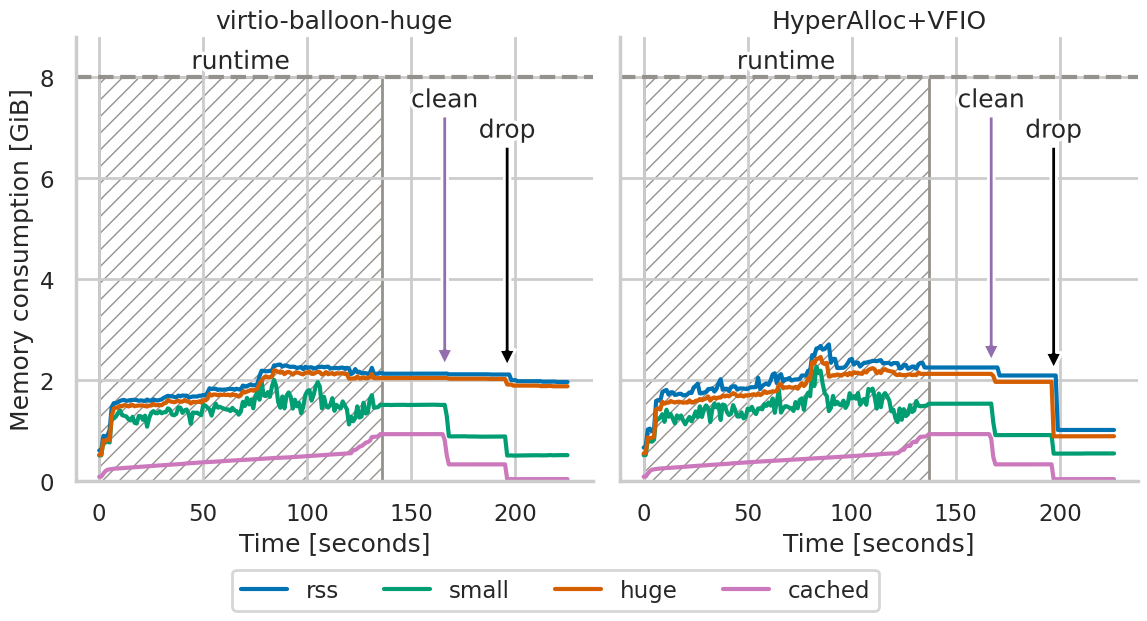

In [13]:
max_mem = 8*1024**3
p = visualize(max_mem, {
    "virtio-balloon-huge": Path("compiling/latest-linux-huge-auto"),
    "HyperAlloc+VFIO": Path("compiling/latest-linux-llfree-auto-vfio"),
})

## Clang

Buddy Baseline: 305.31 GiB*m, 1508 s
Buddy Baseline: delay 12.65 GiB, clean 12.02 GiB, drop 9.05 GiB, 465.76 GiB*m
HyperAlloc Baseline: 306.97 GiB*m, 1478 s
HyperAlloc Baseline: delay 10.66 GiB, clean 7.44 GiB, drop 2.17 GiB, 466.23 GiB*m


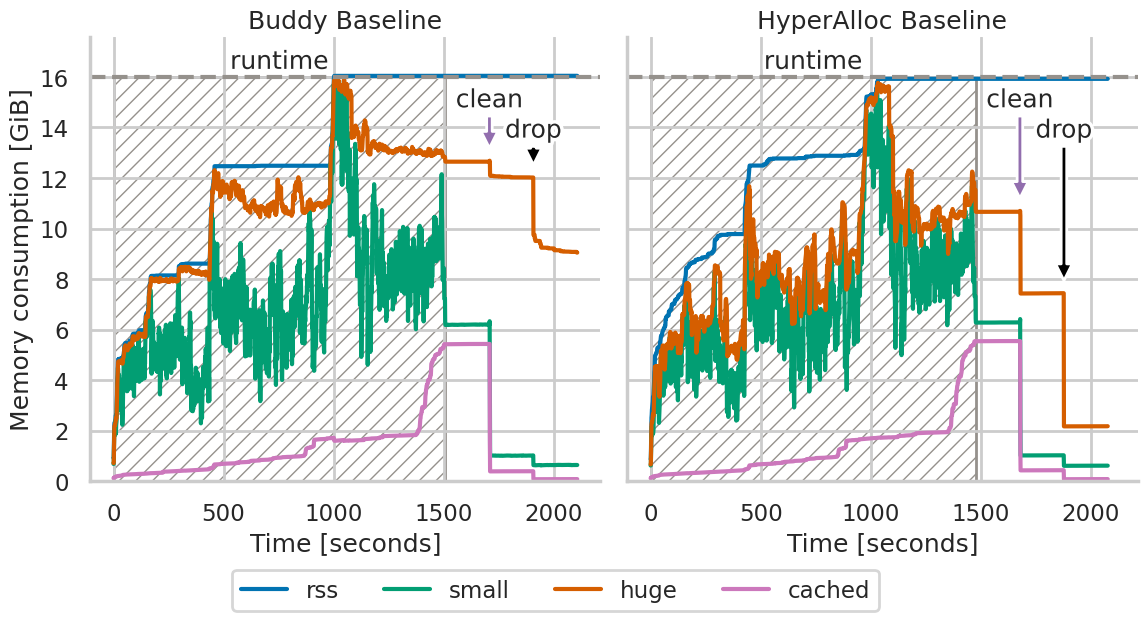

In [14]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "Buddy Baseline": Path("compiling/latest-clang-base-manual"),
    "HyperAlloc Baseline": Path("compiling/latest-clang-llfree-manual"),
})

virtio-balloon: 269.61 GiB*m, 1495 s
virtio-balloon: delay 12.16 GiB, clean 11.46 GiB, drop 8.93 GiB, 380.07 GiB*m
HyperAlloc: 223.70 GiB*m, 1475 s
HyperAlloc: delay 10.85 GiB, clean 7.42 GiB, drop 2.18 GiB, 293.54 GiB*m


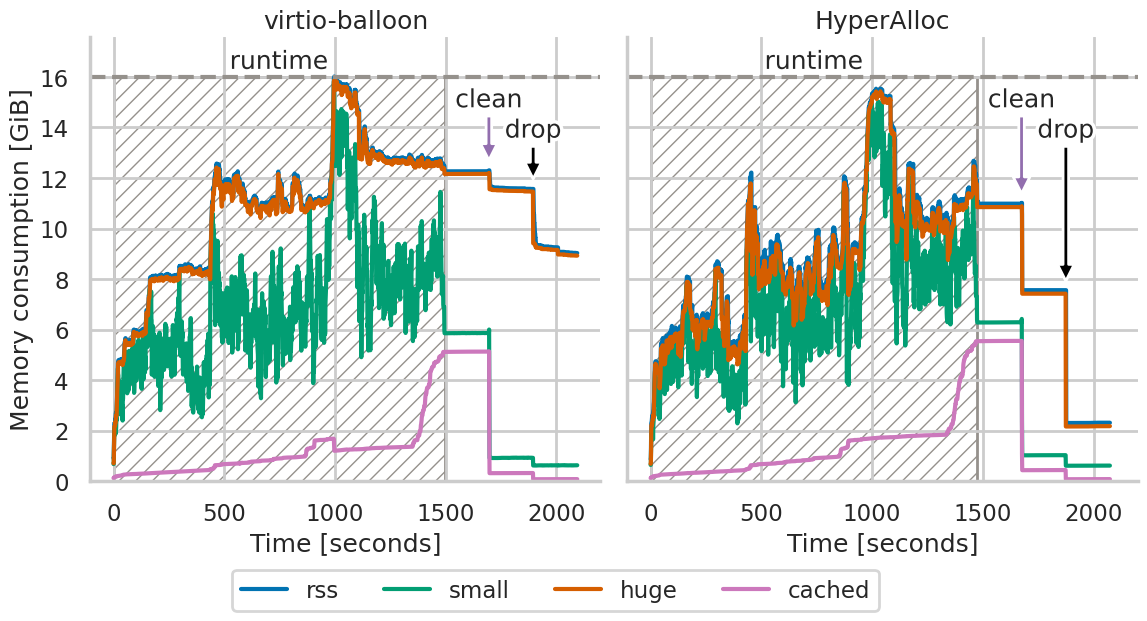

In [15]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "virtio-balloon": Path("compiling/latest-clang-base-auto"),
    "HyperAlloc": Path("compiling/latest-clang-llfree-auto"),
}, "clang-auto")

virtio-balloon-huge: 275.05 GiB*m, 1499 s
virtio-balloon-huge: delay 12.68 GiB, clean 11.88 GiB, drop 9.28 GiB, 389.37 GiB*m
HyperAlloc+VFIO: 226.18 GiB*m, 1478 s
HyperAlloc+VFIO: delay 11.06 GiB, clean 7.25 GiB, drop 2.05 GiB, 296.22 GiB*m


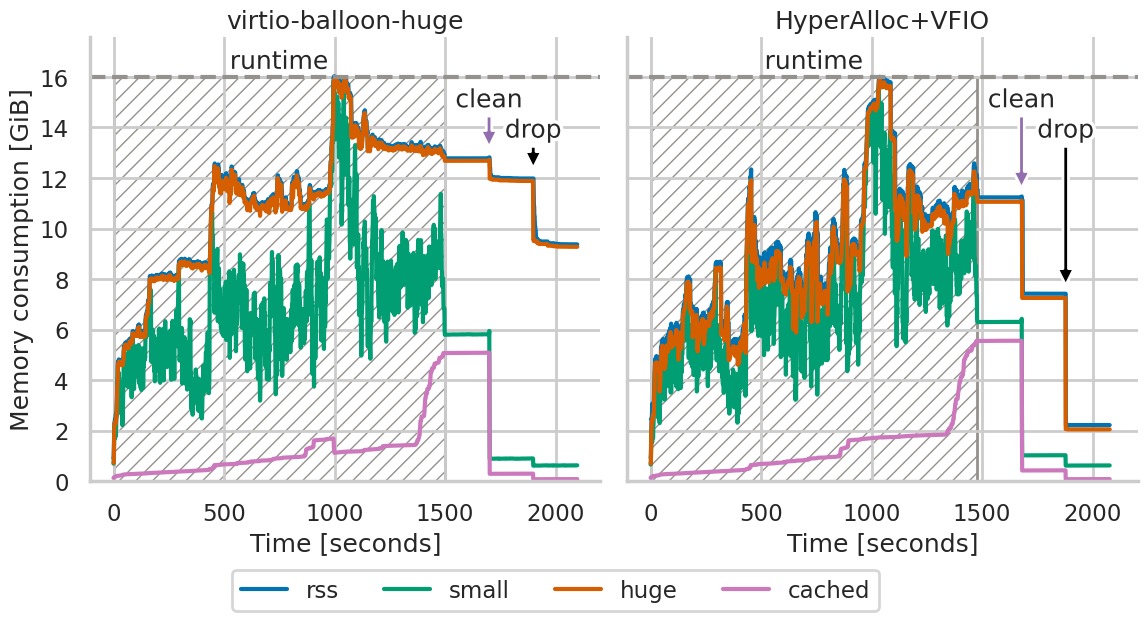

In [16]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "virtio-balloon-huge": Path("compiling/latest-clang-huge-auto"),
    "HyperAlloc+VFIO": Path("compiling/latest-clang-llfree-auto-vfio"),
}, "clang-huge-vfio")

## SPEC17 Blender

virtio-balloon: 41.74 GiB*m, 328 s
virtio-balloon: 42.56 GiB*m, 328 s
virtio-balloon: 43.03 GiB*m, 328 s
virtio-balloon: delay 3.16 GiB, delay 5.00 GiB, delay 5.70 GiB, drop 4.27 GiB, 202.28 GiB*m
HyperAlloc: 41.75 GiB*m, 328 s
HyperAlloc: 42.06 GiB*m, 326 s
HyperAlloc: 42.51 GiB*m, 329 s
HyperAlloc: delay 1.74 GiB, delay 2.13 GiB, delay 2.50 GiB, drop 1.16 GiB, 158.69 GiB*m


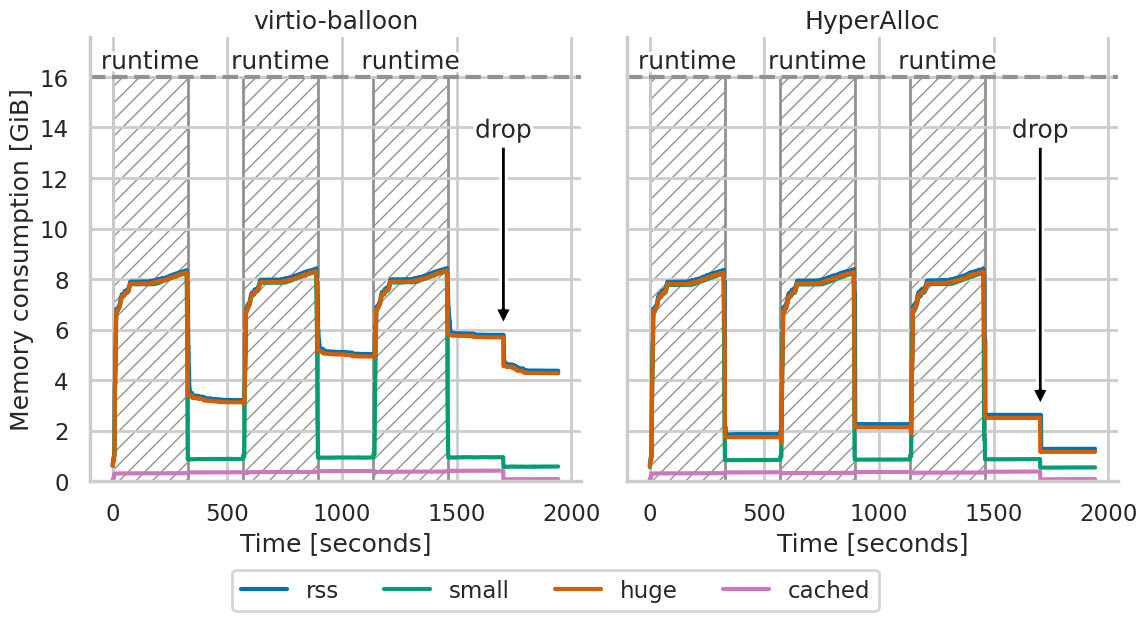

In [17]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "virtio-balloon": Path("compiling/latest-blender-base-auto"),
    "HyperAlloc": Path("compiling/latest-blender-llfree-auto"),
}, "blender-auto")